In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Classe "Gaussian Bundle", validée dans Voting_Gaussians

In [2]:
class GaussianBundle:
    """Class Gaussian Bundle
    - modélise une Gaussienne (avec vecteur moyenne et matrice de covariance)
    - inclut un compteur de datapoints reliés à la Gaussienne
    """
    
    def __init__(self, mu, sigma, ctr=None):
        """constructeur

        Args:
            mu (array of length D): vecteur moyenne
            sigma (array of shape DxD): matrice de covariance. Supposée définie positive.
        """
        
        self.D = mu.shape[0]
        self.mu = mu
        self.sigma = sigma
        if ctr==None:
            self.ctr = 0
        else:
            self.ctr = ctr
        
    def add_point(self, x):
        """ajoute point à la Gaussienne :
        - update mu et covariance
        - ajoute 1 au compteur

        Args:
            x (array of length D): nouveau point
        """
        
        # mini test de dimension
        assert x.shape[0] == self.D, "nouveau point de dimension différente de la Gaussienne de rattachement"
        
        # update vecteur moyenne mu
        n = self.ctr
        mu_n = self.mu 
        self.mu = mu_n * n / (n+1) + 1 / (n+1) * x # calcul mu_n+1
        
        # update covariance
        sigma_n = self.sigma
        self.sigma = n/(n+1) * sigma_n + n/(n+1)**3 * np.matmul((x-mu_n).reshape(self.D,1), (x-mu_n).reshape(1,self.D) ) + 1/(n+1) * np.matmul( (x-self.mu).reshape(self.D,1), (x-self.mu).reshape(1,self.D))
        
        # incrémente compteur
        self.ctr += 1
        
    def pdf(self, x):
        """calcule la pdf de la Gaussienne au point x"""
        determinant = np.linalg.det(self.sigma)
        inverse_sigma = np.linalg.inv(self.sigma)
        pdf = 1/((2*np.pi)**(self.D/2)*determinant**(1/2))*np.exp(-1/2*np.matmul((x-self.mu).reshape(1, self.D), np.matmul(inverse_sigma, (x-self.mu).reshape(self.D,1))))
        return pdf
        
    
    def __str__(self):
        msg = "Gaussian bundle \n" + f"Dimension {self.D} \n" + f"mu = {self.mu} " + f"cov = {self.sigma} \n" + f'points assignés = {self.ctr}'
        return msg
    
    def __repr__(self):
        msg = "Gaussian bundle \n" + f"Dimension {self.D} \n" + f"mu = {self.mu} " + f"cov = {self.sigma} \n" + f'points assignés = {self.ctr}'
        return msg

In [3]:
def calcul_parametres(liste_points):
    """calcul mu et sigma sur une liste de points 2D"""
    
    points = np.array(liste_points)
    # print(points)
    D = points.shape[-1]
    # print(D)
    mu = np.mean( np.array(liste_points), axis=0 )
    # print(mu)
    sigma = 0
    for i in range(len(liste_points)):
        point = points[i]
        sigma = sigma + np.matmul( (point-mu).reshape(D,1), (point-mu).reshape(1,D))
    sigma = 1/len(liste_points) * sigma
        
    return mu, sigma 

# Exemple de comparatif GMM vs Voting Gaussians

### Génération dataset

In [4]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.0
K = 1  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 5000
SIGMA_MAX = 0.10

In [5]:
def create_toy_dataset(n_points=N_POINTS, K=4, p_noise=0.15, pi_gaussiennes=None, sigma_max=None):
    """Create toy dataset of K random 2D gaussians, with noise

    Args:
        n_poins (_type_, optional): total number of points of the dataset. Defaults to N_POINTS.
        K (int, optional): number of gaussians. Defaults to 4.
        p_noise (float, optional): probability of sampling a noise point. Defaults to 0.15.
        p_gaussiennes (_type_, optional): list of probabilities of sampling from each gaussian. sums to 1-p_noise. Defaults to None.
        
    - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
    - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes
    """
    
    if pi_gaussiennes==None:
        pi_gaussiennes = [(1-p_noise)/K] * K
    
    points = np.zeros(shape=(n_points,2))
    labels = np.zeros(shape=(n_points))
    choices = np.arange(K)

    # create Gaussians
    mus = np.random.uniform(low=-1.0, high=1.0, size=(K,2))
    
    if sigma_max==None:
        sigma_max = SIGMA_MAX
    covs = np.zeros(shape=(K,2,2))

    for i in range(K):
        diag = np.array( [ [np.random.uniform(low=0.0, high=sigma_max),0], [0, np.random.uniform(low=0.0, high=sigma_max)] ] )
        theta = np.random.uniform(low=0, high=2*np.pi)
        ortho = np.array( [ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        covs[i] = np.matmul( np.transpose(ortho), np.matmul(diag, ortho) )
        
    rng = np.random.default_rng()

    for i in range(n_points):
        p = np.random.uniform()
        if p <= p_noise:
            point = np.random.uniform(low=-1.0-sigma_max*3, high=1+sigma_max*3, size=2)
            label = -1
        else:
            n_gaussienne = np.random.choice(choices)
            label = n_gaussienne
            mu = mus[n_gaussienne]
            sigma = covs[n_gaussienne]
            point = rng.multivariate_normal(mean=mu, cov=sigma)
        points[i] = point
        labels[i] = label
        
    return points, labels, mus, covs, sigma_max

In [6]:
p_noise = 0.2
K = 4  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 5000

points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes)

In [7]:
def pdf(mu, cov, x):
    """calcule pdf du point x wrt gaussienne (mu, cov)"""
    determinant = np.linalg.det(cov)
    inverse_sigma = np.linalg.inv(cov)
    D = mu.shape[0]
    pdf = 1/(((2*np.pi)**(D/2))*determinant**(1/2))*np.exp(-1/2*np.matmul((x-mu), np.matmul(inverse_sigma, (x-mu))))
    pdf = pdf.flatten()[0]
    
    return pdf

In [8]:
def display_dataset(points, labels, mus, covs, sigma_max):
    """display dataset"""
    
    fig, ax  = plt.subplots(figsize=(6,6))

    # affiche tous les points
    ax.scatter(points[:,0], points[:,1], c=labels, marker='.', s=2.0, alpha=1.0)
    ax.set_xlim(left=-1.0-sigma_max*5, right=1+sigma_max*5)
    ax.set_ylim(bottom=-1.0-sigma_max*5, top=1+sigma_max*5)
    ax.grid(True)
    
    # affiche les centres des gaussiennes et des contours
    K = mus.shape[0]
    
    for i in range(K):
        # affiche centre
        x_mu = mus[i,0]
        y_mu = mus[i,1]
        ax.scatter(x_mu, y_mu, label=f'Gaussienne {K}', s=100.0, marker='x')
        # calcule contours
        delta = 1.0
        nx = 20
        x = np.linspace( x_mu - delta, x_mu + delta, num=nx)
        # print(x)
        ny = 20
        y = np.linspace( y_mu - delta, y_mu + delta, num=ny)
        # print(y)
        X, Y = np.meshgrid(x, y) # X a shape nx.ny, Y a shape nx.ny
        # print(X)
        # print(Y)
        Z = np.zeros(shape=(ny,nx))
        for j in range(ny):
            for k in range(nx):
                xc = X[j,k]
                yc = Y[j,k]
                point = np.array([xc,yc])
                # print(point)
                Z[j,k] = pdf(mus[i], covs[i], point)
        ax.contour(X,Y,Z)

    return fig, ax

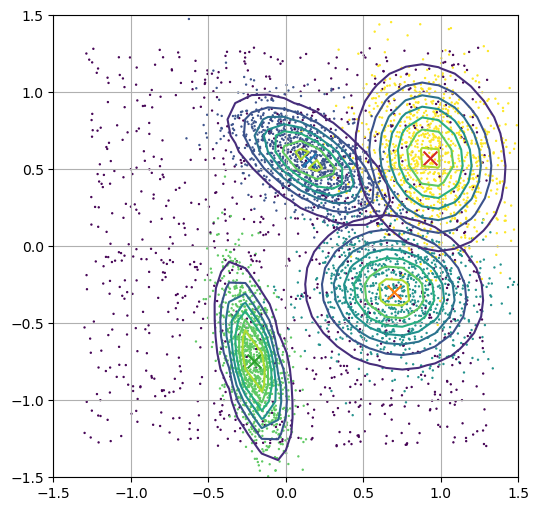

In [9]:
# points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes)

fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

### Baseline : Bayesian Gaussian Mixture sur tout le dataset

In [10]:
from sklearn.mixture import BayesianGaussianMixture

In [11]:
dpbgm = BayesianGaussianMixture(
    n_components = K*3, # max number of components, will be infered by data
    weight_concentration_prior_type = 'dirichlet_process',   # weight concentration prior is Dirchlet process : (approximate) infinite number of components
    random_state = 42,
    reg_covar = 1e-6,
    verbose = 3,
    max_iter = 2000,
)

dpbgm.fit(points)

Initialization 0
  Iteration 10	 time lapse 0.86584s	 ll change 2.66465
  Iteration 20	 time lapse 0.49285s	 ll change 0.82488
  Iteration 30	 time lapse 0.52010s	 ll change 0.69480
  Iteration 40	 time lapse 0.60431s	 ll change 0.93682
  Iteration 50	 time lapse 0.50550s	 ll change 1.14385
  Iteration 60	 time lapse 0.51119s	 ll change 0.43449
  Iteration 70	 time lapse 0.56783s	 ll change 0.22557
  Iteration 80	 time lapse 0.40314s	 ll change 0.23621
  Iteration 90	 time lapse 0.47211s	 ll change 0.26960
  Iteration 100	 time lapse 0.35624s	 ll change 0.38135
  Iteration 110	 time lapse 0.37895s	 ll change 0.24174
  Iteration 120	 time lapse 0.41293s	 ll change 0.03575
  Iteration 130	 time lapse 0.46973s	 ll change 0.03046
  Iteration 140	 time lapse 0.52008s	 ll change 0.02626
  Iteration 150	 time lapse 0.42107s	 ll change 0.02287
  Iteration 160	 time lapse 0.45373s	 ll change 0.02014
  Iteration 170	 time lapse 0.47942s	 ll change 0.01790
  Iteration 180	 time lapse 0.46092s	 ll

BayesianGaussianMixture(max_iter=2000, n_components=12, random_state=42,
                        verbose=3)

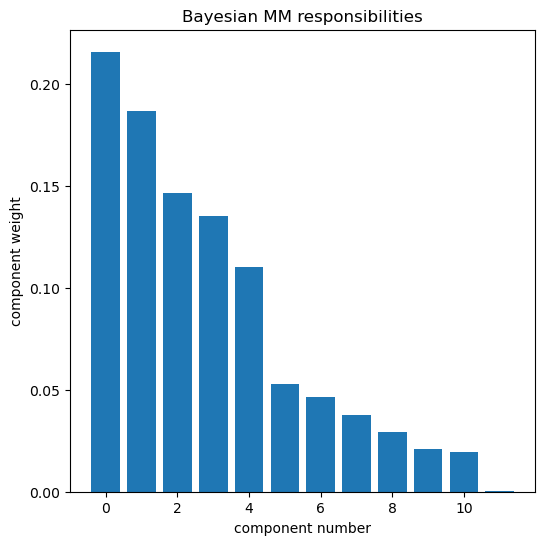

In [12]:
comp_number = [ x for x in range(K*3) ]
responsibilities = sorted(list(dpbgm.weights_),reverse=True)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(comp_number, responsibilities)
ax.set_xlabel('component number')
ax.set_ylabel('component weight')
# ax.set_yscale("log")
ax.set_title(f'Bayesian MM responsibilities')
plt.show()

In [13]:
idx = np.argpartition(dpbgm.weights_, -K)[-K:]  # indices des plus K grandes responsabilités
resp = dpbgm.weights_[idx]

In [14]:
print('Responsabilités dataset :')
print(pi_gaussiennes)
print(f'Top {K} responsabilités inférées par le modèle :')
print(resp)

Responsabilités dataset :
[0.2, 0.2, 0.2, 0.2]
Top 4 responsabilités inférées par le modèle :
[0.13508303 0.14625034 0.21561833 0.18638625]


In [15]:
print(f'Moyennes des {K} gaussiennes du dataset :')
print(np.sort(mus[:K], axis=0))
print(f'Moyennes des {K} gaussiennes inférées par le modèle :')
print(np.sort(dpbgm.means_[idx], axis=0))

Moyennes des 4 gaussiennes du dataset :
[[-0.20899264 -0.7443782 ]
 [ 0.14718669 -0.29904598]
 [ 0.69802945  0.56074948]
 [ 0.93112366  0.57499433]]
Moyennes des 4 gaussiennes inférées par le modèle :
[[-0.20992138 -0.73574833]
 [ 0.16683527 -0.3259578 ]
 [ 0.7968977   0.44185154]
 [ 0.97939135  0.54793626]]


# Implémentation algo "voting Gaussians"

inspiré de https://ieeexplore.ieee.org/document/5589161 (voted spheres)

In [162]:
# create dataset 

p_noise = 0.05
K_init = 3  # nombre de Gaussiennes
K = K_init
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 5000
sigma_max = 0.05

In [163]:
points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise)

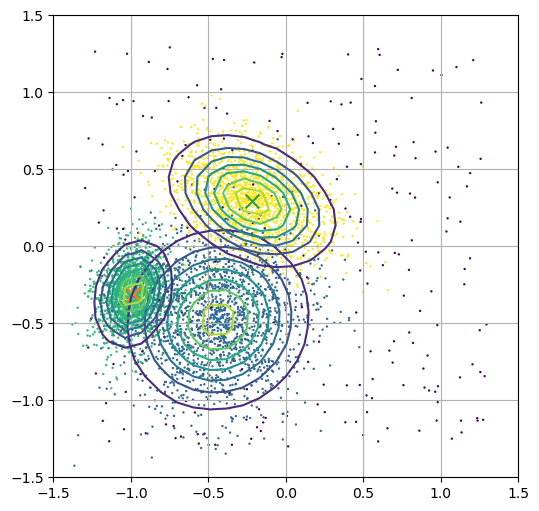

In [164]:
# affiche

fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

In [165]:
print(mus)

[[-0.43808265 -0.47685596]
 [-0.98518232 -0.30987642]
 [-0.2182344   0.29291174]]


In [166]:
print(covs)

[[[ 0.08388206  0.00416122]
  [ 0.00416122  0.08352001]]

 [[ 0.01386035  0.00418191]
  [ 0.00418191  0.02728785]]

 [[ 0.06858101 -0.01854946]
  [-0.01854946  0.04267825]]]



### Description de l'algorithme :

Define seuil theta (seuil de pdf en dessous duquel on considère qu'un point "n'appartient pas" à une Gaussienne)

TRAINING
- While point x dans dataset, do:
-    Retrieve S ensemble des Gaussiennes tq pdf(x) >= theta (seuil) # ensemble des Gaussiennes qui contiennent x avec une bonne vraisemblance
-    If S est vide:
-        create nouvelle Gaussienne, centre x, covariance sigma = ?
-    Sinon:
-        for all Gaussienne dans S:
-            - update mu, sigma de la Gaussienne avec le point x
-            - augmente compteur de la Gaussienne
-    End if
- End while

LABELLISATION
- For all point x in dataset, do:
-    Retrieve S ensemble des Gaussiennes tq pdf(x) >= theta
-        Calculate nombre de votes = sum G.ctr for G in S # somme des tailles de Gaussiennes contenant x

In [167]:
sigma_init = .05
cov_init = np.array([[sigma_init**2, 0],[0, sigma_init**2]]) 
determinant = np.linalg.det(cov_init)

# antisèche
# pdf mu en 2D

pdf_2D = 1/(((2*np.pi)**(2/2))*determinant**(1/2))

print(pdf_2D)

63.66197723675812


In [168]:
# initialisation, paramètres

liste_gaussiennes = []  # liste des objets Gaussian Bundles inférées par le modèle
seuil_appartenance = 0.1  # seuil de pdf en dessous duquel on va créer une nouvelle Gaussian Bundle

In [169]:
cov_init = np.array([[sigma_init**2, 0],[0, sigma_init**2]])  # matric covariance initiale pour une nouvelle Gaussian Bundle

# parcourt tous les points séquentiellement
for point in points:
    
    K = len(liste_gaussiennes) # nombre total de gaussiennes en cours
    
    # cherche l'ensemble des gaussiennes "contenant" le point
    K_appartenance = 0
    for g in liste_gaussiennes:
        if g.pdf(point) >= seuil_appartenance:
            # print(f'ajoute point à la gaussienne {g}')
            g.add_point(point)  # ajoute point à la gaussienne g : incrémente compteur, recalcule mu et sigma
            K_appartenance += 1
            
    if K_appartenance == 0: # si aucune gaussienne ne 'contient' le point, crée une nouvelle Gaussian Bundle
        gb = GaussianBundle(mu=point, sigma=cov_init, ctr=1)
        liste_gaussiennes.append(gb)

In [170]:
print(f'{len(liste_gaussiennes)} créée(s)')

106 créée(s)


In [171]:
mus_bundle = np.array( [gb.mu for gb in liste_gaussiennes] )
covs_bundle = np.array( [gb.sigma for gb in liste_gaussiennes] )
K = mus_bundle.shape[0]

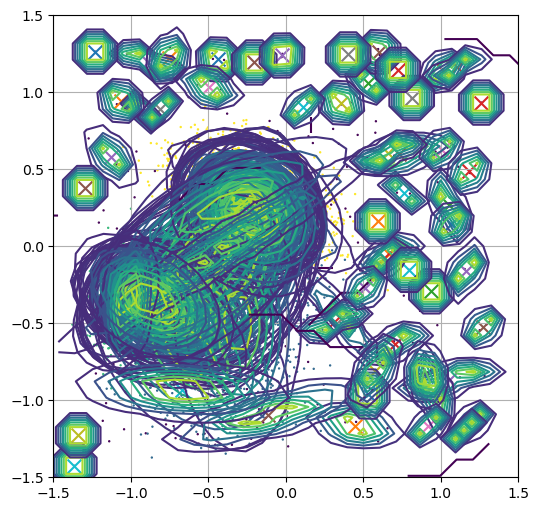

In [172]:
fig, ax = display_dataset(points, labels, mus_bundle, covs_bundle, sigma_max)

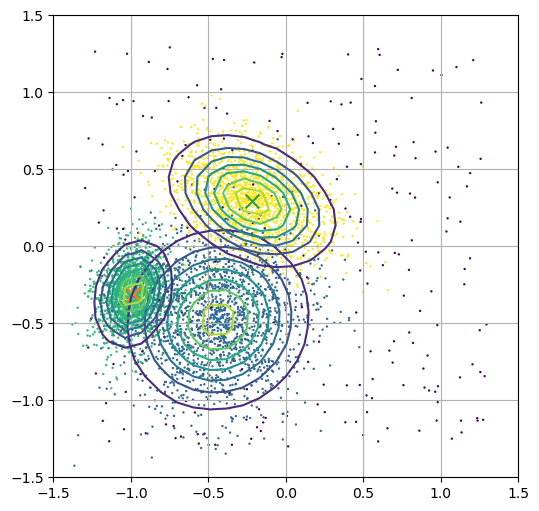

In [173]:
fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

In [174]:
ctrs = np.array( [ gb.ctr for gb in liste_gaussiennes ] )

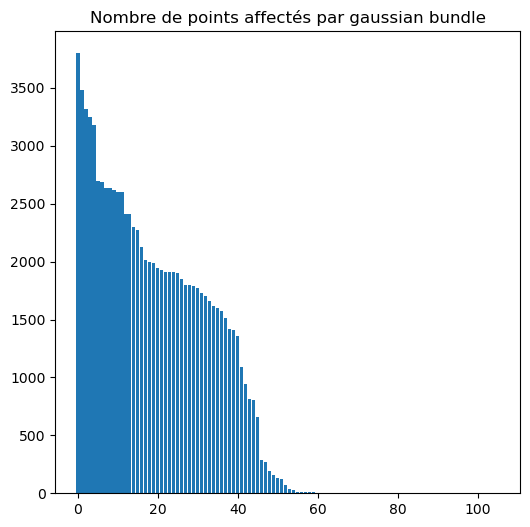

In [175]:
fig, ax  = plt.subplots(figsize=(6,6))

x = np.array([i for i in range(len(ctrs))])

ax.bar(x=x, height=sorted(ctrs, reverse=True))
ax.set_title(f'Nombre de points affectés par gaussian bundle')
plt.show()

In [176]:
idx = np.argpartition(ctrs, -K_init)[-K_init:]  # indices des K gaussiennes avec le plus de points affectés

mus_gb = np.array( [ gb.mu for gb in liste_gaussiennes ])
covs_gb = np.array( [ gb.sigma for gb in liste_gaussiennes ])

In [177]:
idx

array([ 9,  2, 12])

In [178]:
points_affectes = ctrs[idx]  # les nombres
mus_affectes = mus_gb[idx]
covs_affectes = covs_gb[idx]

In [179]:
print(np.sort(mus_affectes, axis=0))

[[-0.6021865  -0.2059971 ]
 [-0.57387934 -0.1361829 ]
 [-0.55499944 -0.10974934]]


In [180]:
print(np.sort(mus, axis=0))

[[-0.98518232 -0.47685596]
 [-0.43808265 -0.30987642]
 [-0.2182344   0.29291174]]
